In [1]:
import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn import metrics
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
# , ticker as mticker

plt.style.use('seaborn-notebook')

%matplotlib inline

In [2]:
orig_data = pd.read_csv('../data/kc_house_data.csv', index_col=0).dropna()
df = orig_data.copy()

In [3]:
def nfind(str, c, n):
  if n >= 0:
    idx = -1
    for i in range(n):
      idx = str.find(c, idx + 1)
    return idx
  idx = str.rfind(c)
  for i in range(-n - 1):
    str = str[:idx]
    idx = str.rfind(c)
  return idx

df['state'] = df.address.apply(lambda x: x[nfind(x, ',', -2) + 2:x.rfind(',') - 6])
df = df[df['state'] == 'Washington']
highquant_price = df['price'].quantile(0.99)
highquant_living = df['sqft_living'].quantile(0.99)
highquant_lot = df['sqft_lot'].quantile(0.99)
highquant_basement = df['sqft_basement'].quantile(0.99)
highquant_patio = df['sqft_patio'].quantile(0.99)
highquant_garage = df['sqft_garage'].quantile(0.99)
df = df[df['price'] < highquant_price]
df = df[df['sqft_living'] < highquant_living]
df = df[df['sqft_living'] > 100] # Gets rid of abnormally low sqfts
    
df = df[df['sqft_lot'] < highquant_lot]
    
df = df[df['sqft_basement'] < highquant_basement]
    
df = df[df['sqft_patio'] < highquant_patio]
    
df = df[df['sqft_garage'] < highquant_garage]

In [4]:
df['age'] = 2021 - df['yr_built']

df['bath_to_bed'] = df['bathrooms'] / df['bedrooms']
df = df.replace([np.inf, -np.inf], df['bath_to_bed'].median()).fillna(df['bath_to_bed'].median()) # Replaces inf/-inf/nan values with median

df['zip'] = df.address.apply(lambda x: x[x.rfind(',') - 5:x.rfind(',')])
    
df['condition'] = df['condition'].replace({'Poor': 1, 
                                               'Fair': 2, 
                                               'Average': 3, 
                                               'Good': 4, 
                                               'Very Good': 5})
df['grade'] = df['grade'].replace({'1 Cabin': 1, 
                                       '2 Substandard': 2, 
                                       '3 Poor': 3, 
                                       '4 Low': 4, 
                                       '5 Fair': 5,
                                       '6 Low Average': 6,
                                       '7 Average': 7,
                                       '8 Good': 8,
                                       '9 Better': 9,
                                       '10 Very Good': 10,
                                       '11 Excellent': 11,
                                       '12 Luxury': 12,
                                       '13 Mansion': 13,
                                      })
df['heat_source'] = df['heat_source'].replace({'Gas': 1, 'Electricity' : 2, 'Oil': 3, 'Gas/Solar': 4, 'Electricity/Solar':5, 'Oil/Solar':6, 'Other':7 })

In [5]:
historic = df[df['yr_built'] < 1972]
historic['Renovation'] = historic['yr_renovated'].apply(lambda x: 1 if x > 0 else 0)
historic['Renovation_Age'] = historic['yr_renovated'].apply(lambda x: 2022-x if x > 0 else 0)

<ipython-input-5-0046254fe4bc>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  historic['Renovation'] = historic['yr_renovated'].apply(lambda x: 1 if x > 0 else 0)
<ipython-input-5-0046254fe4bc>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  historic['Renovation_Age'] = historic['yr_renovated'].apply(lambda x: 2022-x if x > 0 else 0)


In [6]:
historic_corr = historic.corr()['price'].map(abs).sort_values(ascending=False)
historic_corr

price             1.000000
grade             0.575724
sqft_living       0.563997
bathrooms         0.481746
sqft_above        0.481224
lat               0.388197
floors            0.333290
sqft_basement     0.332058
bedrooms          0.287049
bath_to_bed       0.275654
sqft_patio        0.242300
yr_renovated      0.163007
Renovation        0.162569
age               0.114110
yr_built          0.114110
Renovation_Age    0.099847
condition         0.099640
heat_source       0.099441
sqft_garage       0.097830
long              0.040585
sqft_lot          0.025151
Name: price, dtype: float64

In [7]:
target = historic['price']

In [8]:
historic_pred1 = historic[['grade']]
target = historic['price']
historic_with_con = sm.add_constant(historic_pred1)
model1 = sm.OLS(endog=target, exog=historic_pred1).fit()
model1.rsquared
#Grade accounts for 80% of variation in price
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.798
Model:                            OLS   Adj. R-squared (uncentered):              0.798
Method:                 Least Squares   F-statistic:                          5.171e+04
Date:                Thu, 15 Sep 2022   Prob (F-statistic):                        0.00
Time:                        13:20:36   Log-Likelihood:                     -1.9065e+05
No. Observations:               13120   AIC:                                  3.813e+05
Df Residuals:                   13119   BIC:                                  3.813e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
grade        1.39e+05    611.166    227.392      0.000    1.38e+05     1.4e+05
==============================================================================
Omnibus:                     5458.675   Durbin-Watson:                   1.978
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            28398.786
Skew:                           1.966   Prob(JB):                         0.00
Kurtosis:                       9.040   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [9]:
historic_pred2 = historic[['sqft_living', 'grade',]]
historic_with_con2 = sm.add_constant(historic_pred2)
model2 = sm.OLS(endog=target, exog=historic_pred2).fit()
model2.rsquared
# SQ_ft living and Grade accounts for 68% of variation in price
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.833
Model:                            OLS   Adj. R-squared (uncentered):              0.833
Method:                 Least Squares   F-statistic:                          3.280e+04
Date:                Thu, 15 Sep 2022   Prob (F-statistic):                        0.00
Time:                        13:20:36   Log-Likelihood:                     -1.8937e+05
No. Observations:               13120   AIC:                                  3.788e+05
Df Residuals:                   13118   BIC:                                  3.788e+05
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
sqft_living   350.5419      6.611     53.023      0.000     337.583     363.501
grade        5.007e+04   1766.022     28.353      0.000    4.66e+04    5.35e+04
==============================================================================
Omnibus:                     5135.807   Durbin-Watson:                   1.976
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            31675.245
Skew:                           1.764   Prob(JB):                         0.00
Kurtosis:                       9.746   Cond. No.                         851.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [10]:
historic_pred3 = historic[['grade', 'condition', 'age']]
historic_with_con3 = sm.add_constant(historic_pred3)
model3 = sm.OLS(endog=target, exog=historic_pred3).fit()
model3.rsquared
model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.801
Model:                            OLS   Adj. R-squared (uncentered):              0.801
Method:                 Least Squares   F-statistic:                          1.757e+04
Date:                Thu, 15 Sep 2022   Prob (F-statistic):                        0.00
Time:                        13:20:36   Log-Likelihood:                     -1.9055e+05
No. Observations:               13120   AIC:                                  3.811e+05
Df Residuals:                   13117   BIC:                                  3.811e+05
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
grade       1.772e+05   3040.314     58.270      0.000    1.71e+05    1.83e+05
condition   -6.71e+04   4950.706    -13.554      0.000   -7.68e+04   -5.74e+04
age         -324.5322    195.931     -1.656      0.098    -708.586      59.521
==============================================================================
Omnibus:                     5157.053   Durbin-Watson:                   1.973
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            25361.682
Skew:                           1.861   Prob(JB):                         0.00
Kurtosis:                       8.704   Cond. No.                         101.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [11]:
#SHOULD I SCALE THIS?

historic_pred3_scld = (historic_pred3 - historic_pred3.mean()) / historic_pred3.std(ddof=0)
ss = StandardScaler()
ss.fit(historic_pred3)
historic_pred3_scld1 = ss.transform(historic_pred3)
historic_pred3_scld1
np.allclose(historic_pred3_scld1, historic_pred3_scld)
historic_pred3_scld.head()

,grade,condition,age
id,,,
7399300360,-0.018692,0.403708,-1.228512
8910500230,-0.018692,-0.862827,-0.248411
1180000275,-0.018692,-0.862827,-0.557916
2807100156,-0.018692,-0.862827,-0.145242
5122400111,2.283986,0.403708,-0.299995


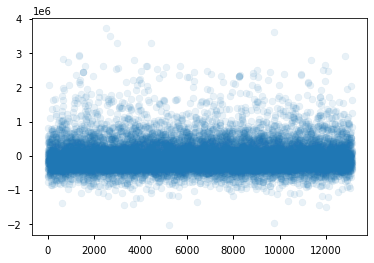

In [12]:
lr = LinearRegression()
lr.fit(historic_pred3_scld, target)
lr.coef_
lr.intercept_
lr.score(historic_pred3_scld, target)
y_hat = lr.predict(historic_pred3_scld)
y_hat
residual = (target - y_hat)
fig, ax = plt.subplots()
ax.scatter(x=range(y_hat.shape[0]),y=residual, alpha=0.1);

In [13]:
metrics.r2_score(target, lr.predict(historic_pred3_scld))
test_target_mean = np.mean(target)
qty = len(target)
metrics.r2_score(target, test_target_mean * np.ones(qty))
metrics.mean_squared_error(target, lr.predict(historic_pred3_scld))
metrics.mean_absolute_error(target, lr.predict(historic_pred3_scld))

305668.11175939057

In [14]:
cond_mean = historic.groupby('condition')['price'].mean()
cond_median = historic.groupby('condition')['price'].median()
grade_mean = historic.groupby('grade')['price'].mean()
grade_median =historic.groupby('grade')['price'].median()

bathroom_mean = historic.groupby('grade')['bathrooms'].mean()
bathroom_median= historic.groupby('grade')['bathrooms'].median()

print(bathroom_mean)
print(bathroom_median)

cond_mean
cond_median
grade_mean
grade_median


grade
3     1.000000
4     1.013158
5     1.137883
6     1.332037
7     1.824695
8     2.431373
9     2.943601
10    3.357843
11    3.633333
12    4.000000
Name: bathrooms, dtype: float64
grade
3     1.0
4     1.0
5     1.0
6     1.0
7     2.0
8     2.5
9     3.0
10    3.5
11    3.5
12    4.0
Name: bathrooms, dtype: float64


grade
3      537500.0
4      480000.0
5      491000.0
6      575000.0
7      800000.0
8     1251500.0
9     1975000.0
10    2600000.0
11    3100000.0
12    3200000.0
Name: price, dtype: float64

In [15]:
historic['bathrooms'].value_counts()

2.0    4389
1.0    4172
3.0    1496
1.5    1310
2.5    1175
3.5     328
4.0     181
4.5      41
5.0      10
6.0       6
0.0       4
0.5       3
6.5       2
7.5       2
5.5       1
Name: bathrooms, dtype: int64

C:\Users\paperspace\anaconda3\envs\learn-env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


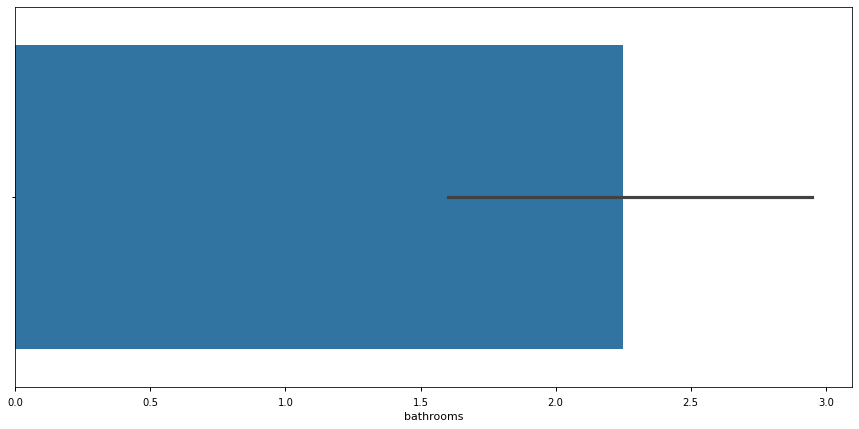

In [16]:
fig,ax = plt.subplots(figsize = (15,7))

ax = sns.barplot(bathroom_median)
# ax.set_xlim(65.5,72.5)
# ax.set_xlabel('Median Profit Margin (%)')
# ax.set_title('Profit Margin vs Genre')

950548.2023628049

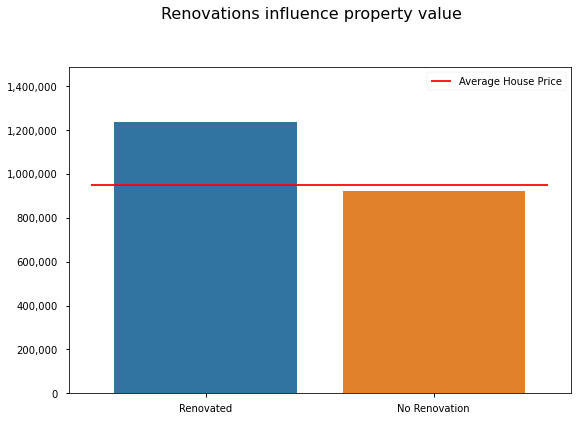

In [17]:
# print(no_renovation_mean)
# print(renovated_mean)
renovated = historic[(historic["Renovation"] == 1)]
renovated_mean = renovated.price.mean()
no_renovation = historic[(historic["Renovation"] == 0)]
no_renovation_mean = no_renovation.price.mean()

label_renovation = ["Renovated", "No Renovation"]
values_renovation = [renovated_mean, no_renovation_mean]

fig, ax = plt.subplots( figsize=(9,6))
sns.barplot(ax=ax, x=label_renovation, y=values_renovation )
ax.get_yaxis().set_major_formatter(
    plt.FuncFormatter(lambda x, p: format(int(x), ',')))


plt.suptitle("Renovations influence property value", size=16, y=1.02)
ax.hlines(historic['price'].mean(), -.5 ,1.5, colors="red", label="Average House Price")
ax.set_ylim(0,1.2*renovated_mean)
ax.legend()
historic['price'].mean()

# # plt.yticks([0, 4000, 8000, 10000, 12000, 14000])



In [18]:
no_renovation.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,greenbelt,nuisance,...,yr_renovated,address,lat,long,state,age,bath_to_bed,zip,Renovation,Renovation_Age
id,,,,,,,,,,,,,,,,,,,,,
7399300360,5/24/2022,675000.0,4,1.0,1180,7140,1.0,NO,NO,NO,...,0,"2102 Southeast 21st Court, Renton, Washington ...",47.461975,-122.190520,Washington,52,0.250000,98055,0,0
8910500230,12/13/2021,920000.0,5,2.5,2770,6703,1.0,NO,NO,YES,...,0,"11231 Greenwood Avenue North, Seattle, Washing...",47.711525,-122.355910,Washington,71,0.500000,98133,0,0
1180000275,9/29/2021,311000.0,6,2.0,2880,6156,1.0,NO,NO,NO,...,0,"8504 South 113th Street, Seattle, Washington 9...",47.502045,-122.225200,Washington,65,0.333333,98178,0,0
2807100156,7/20/2021,625000.0,2,1.0,1190,5688,1.0,NO,NO,YES,...,0,"1602 North 185th Street, Shoreline, Washington...",47.763470,-122.340155,Washington,73,0.500000,98133,0,0
5122400111,11/17/2021,1317227.0,3,3.0,2080,27574,1.0,NO,NO,NO,...,0,"2633 Southwest 164th Place, Burien, Washington...",47.455470,-122.367220,Washington,70,1.000000,98166,0,0


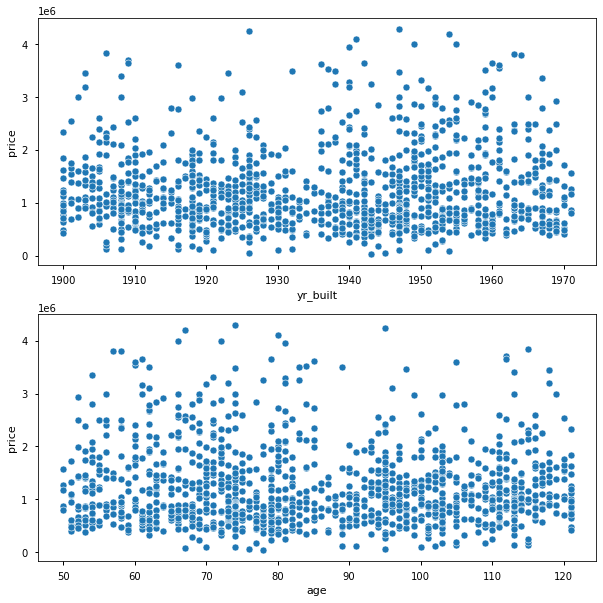

In [19]:

fig, ax = plt.subplots(nrows=2, figsize=(10,10))
sns.scatterplot(x='yr_built', y='price', data=renovated, ax=ax[0])
sns.scatterplot(x='age', y= 'price',
            data=renovated, ax=ax[1])

plt.show()


<AxesSubplot:xlabel='grade', ylabel='price'>

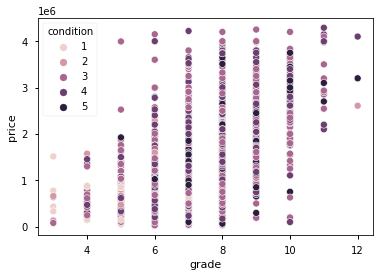

In [20]:
sns.scatterplot(x='grade', y= 'price', hue='condition',data=historic)

In [21]:
stats.ttest_ind(renovated.price, no_renovation.price, equal_var=False)

Ttest_indResult(statistic=14.020985538119012, pvalue=1.2161467837151147e-41)

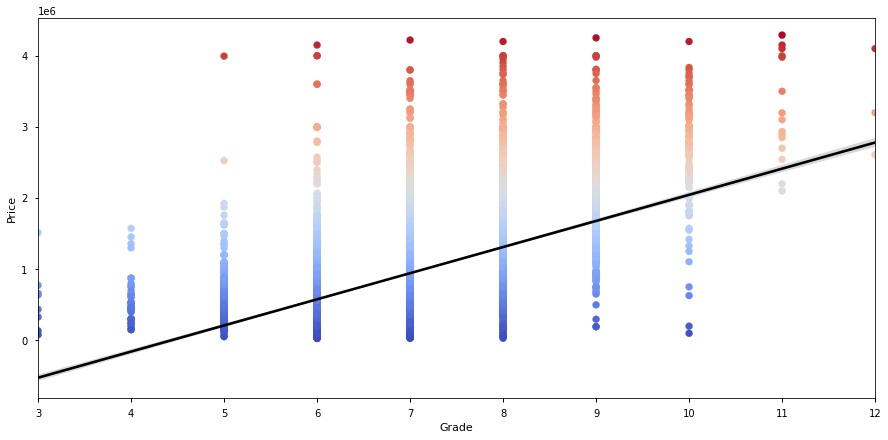

In [22]:
fig, ax = plt.subplots(figsize = (15,7))

ax = sns.regplot(x ='grade', y = 'price', data = historic, scatter = False, color = 'black');
ax.scatter(historic['grade'], historic['price'], c = historic['price'],  cmap="coolwarm");

#ax.hlines(y=60.4, xmin=0, xmax=4e8, linewidth=2, color='cyan')
#ax.vlines(x=0.9e8, ymin=0, ymax=100, linewidth=2, color='cyan')
ax.set_ylabel('Price');
ax.set_xlabel('Grade');

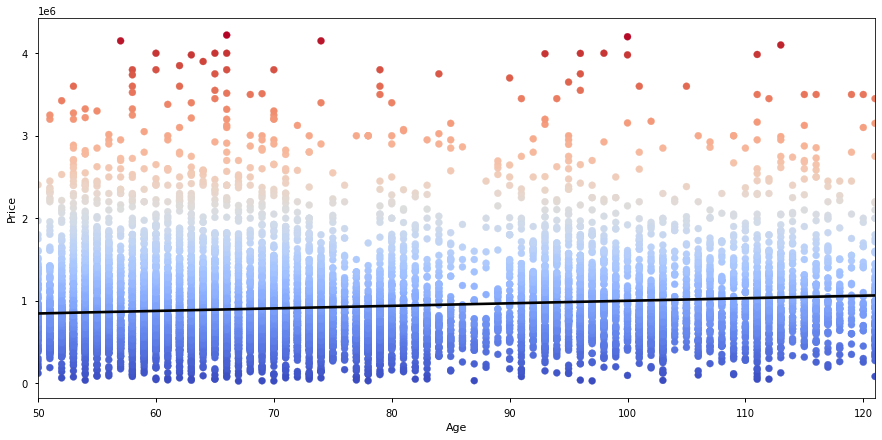

In [23]:
fig, ax = plt.subplots(figsize = (15,7))

ax = sns.regplot(x ='age', y = 'price', data = no_renovation, scatter = False, color = 'black');
ax.scatter(no_renovation['age'], no_renovation['price'], c = no_renovation['price'],  cmap="coolwarm");

#ax.hlines(y=60.4, xmin=0, xmax=4e8, linewidth=2, color='cyan')
#ax.vlines(x=0.9e8, ymin=0, ymax=100, linewidth=2, color='cyan')
ax.set_ylabel('Price');
ax.set_xlabel('Age');

<AxesSubplot:xlabel='condition', ylabel='age'>

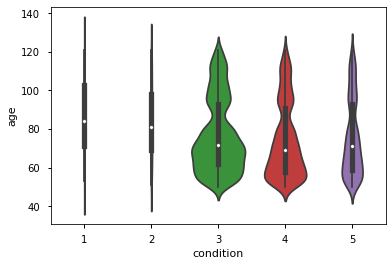

In [24]:
sns.violinplot(data=historic, x="condition", y="age", scale = "count")

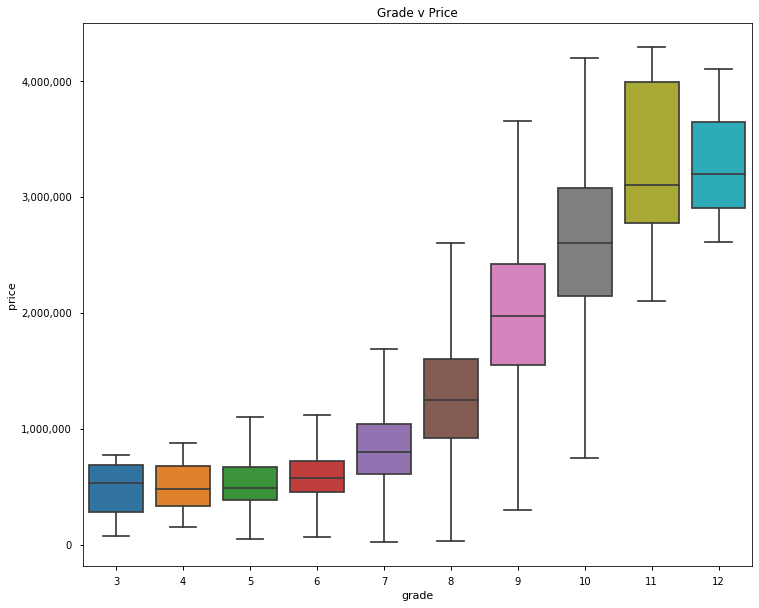

In [25]:
fig, ax = plt.subplots(figsize = (12,10))
ax = sns.boxplot(x = historic['grade'], y = historic['price'], showfliers = False)
ax.get_yaxis().set_major_formatter(
    plt.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.set_title("Grade v Price");

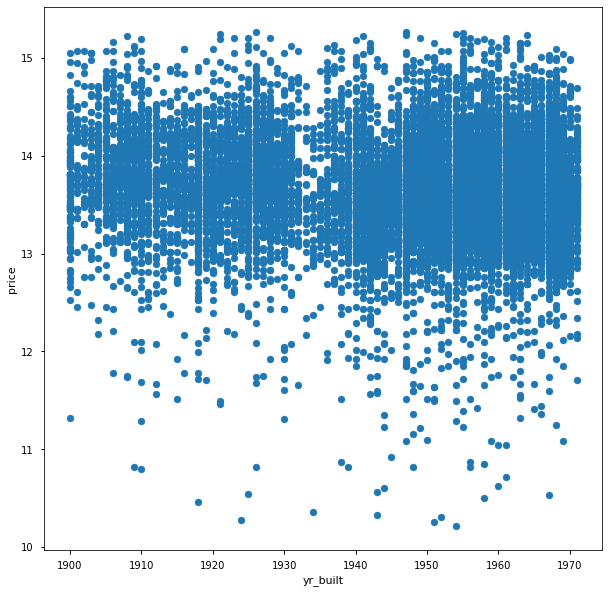

In [26]:
fig, ax = plt.subplots(figsize = (10, 10))
ax.scatter((historic['yr_built']), np.log(historic['price']))
ax.set_xlabel('yr_built')
ax.set_ylabel('price');

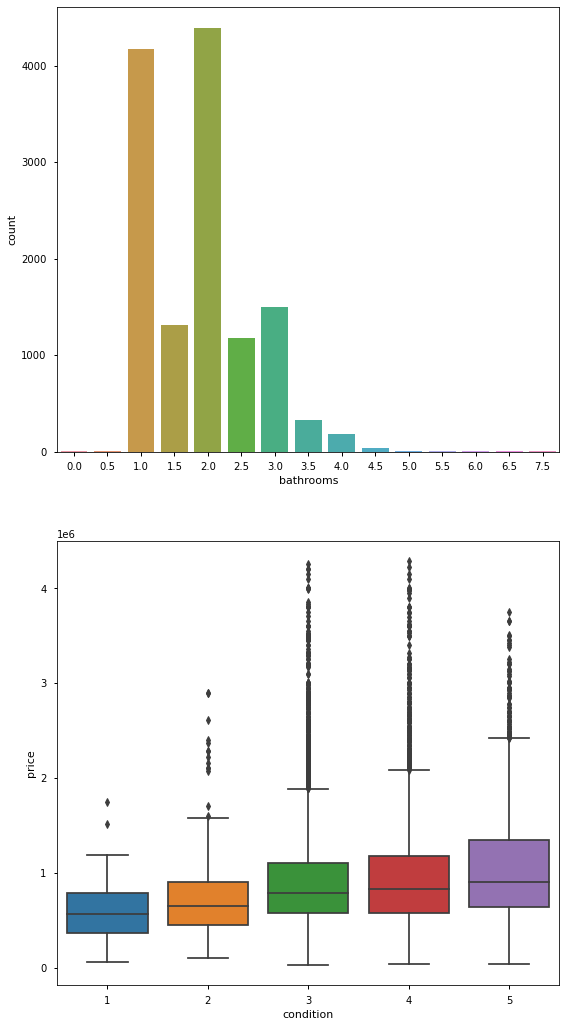

In [27]:
fig, ax = plt.subplots(nrows=2, figsize=(9,18))
sns.countplot(x='bathrooms', data=historic, ax=ax[0])
sns.boxplot(x='condition', y= 'price',
            data=historic, ax=ax[1])
plt.show()


In [28]:
low_grade = historic[historic['grade']<7]
average_grade = historic[(historic['grade'] == 7)]
high_grade = historic[historic['grade']>7]
low_median = low_grade['price'].median()
# print(low_average)
average_median = average_grade['price'].median()
# print(average_average)
high_median = high_grade['price'].median()
# print(high_average)

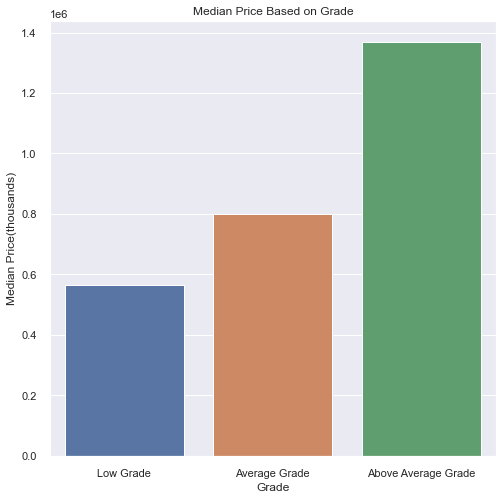

In [34]:
grade_values = [low_median, average_median, high_median]
grade_keys = ['Low Grade', 'Average Grade', 'Above Average Grade']
sns.set(rc = {'figure.figsize':(8,8)})
sns.barplot(x=grade_keys, y=grade_values).set(title='Median Price Based on Grade', xlabel='Grade', ylabel='Median Price(thousands)');
# plt.ticklabel_format(style='plain', axis='y',useOffset=False)

average house in low grade is 626,536; average (most common) 869,867; above average grade is 1,478,998

C:\Users\paperspace\anaconda3\envs\learn-env\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


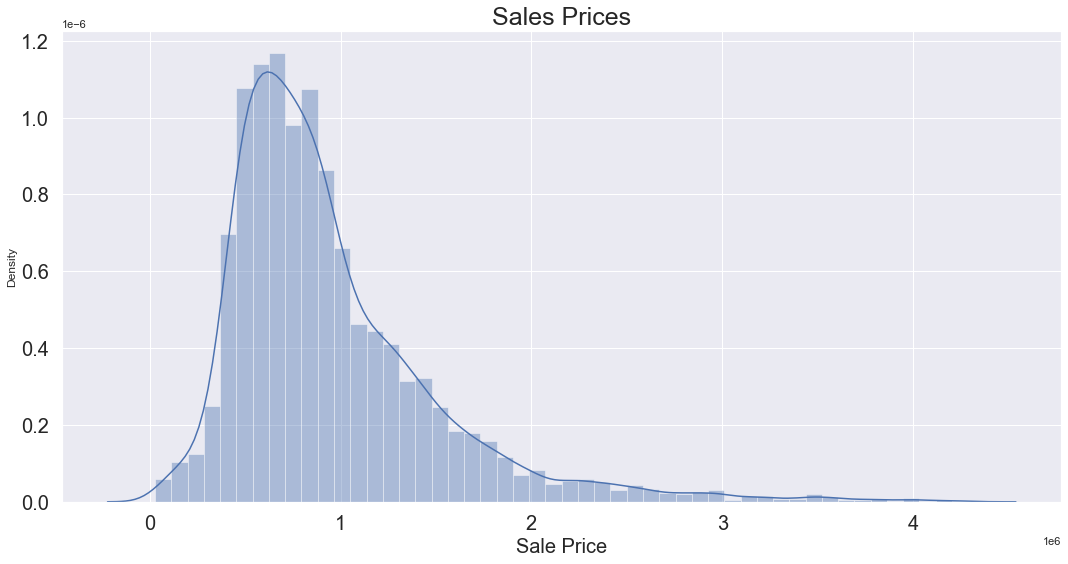

In [30]:
fig, ax = plt.subplots(figsize=(15,8))
ax.set_title('Sales Prices', fontsize = 25)
sns.distplot(historic.price, ax = ax, axlabel = "")
ax.tick_params(axis='both', labelsize=20)
plt.xlabel('Sale Price', fontsize = 20)
plt.tight_layout()

C:\Users\paperspace\anaconda3\envs\learn-env\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


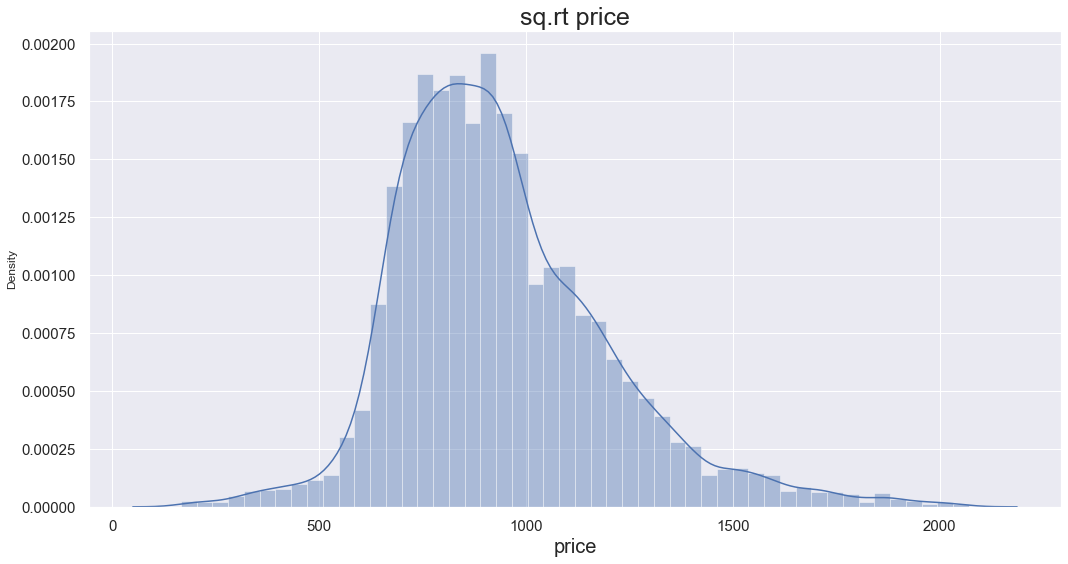

In [31]:
fig, ax = plt.subplots(figsize=(15,8))
plt.title('sq.rt price', fontsize = 25)
sns.distplot(np.sqrt(historic.price), ax = ax)
ax.tick_params(axis = 'both', labelsize = 15)
plt.xlabel('price', fontsize = 20)
plt.tight_layout()

C:\Users\paperspace\anaconda3\envs\learn-env\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


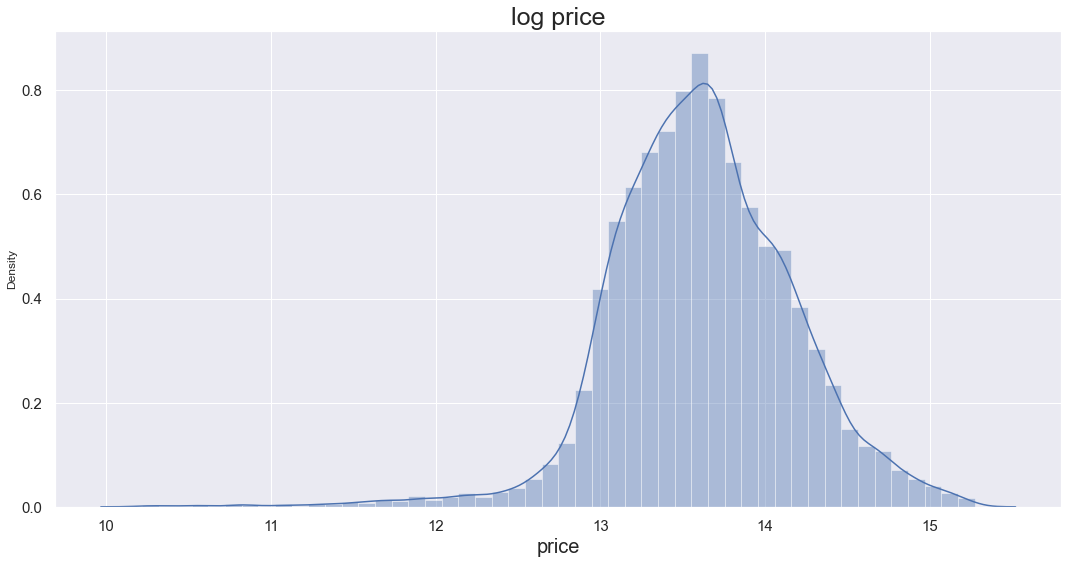

In [32]:
fig, ax = plt.subplots(figsize=(15,8))
plt.title('log price', fontsize = 25)
sns.distplot(np.log(historic.price), ax = ax)
ax.tick_params(axis = 'both', labelsize = 15)
plt.xlabel('price', fontsize = 20)
plt.tight_layout()